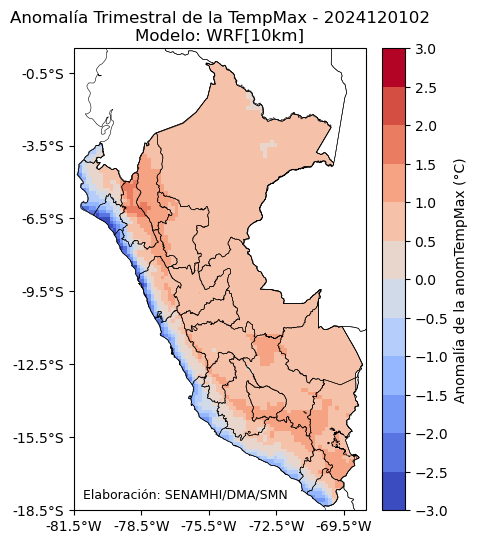

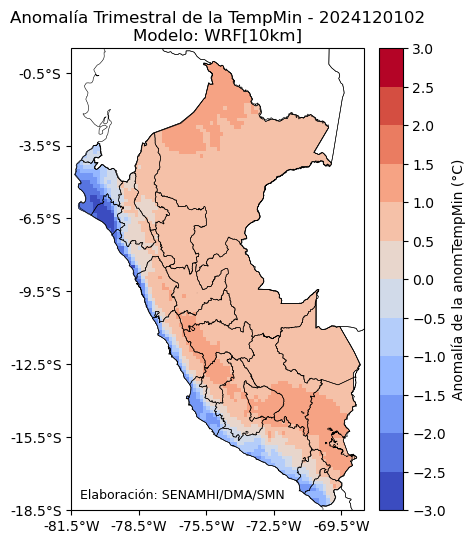

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import os
from matplotlib.colors import BoundaryNorm

base_year = 2024
base_month = 11
base_date_str = f"{base_year}{base_month:02d}"

# Función para añadir meses a una fecha
def add_months_to_date(date, months):
    return date + relativedelta(months=months)

def plot_anomaly_trimestral(archivo_pronostico, archivo_climatologia, variable, output_name, name_title):
    # Abrir los archivos NetCDF sin decodificar el tiempo
    ds_pronostico = xr.open_dataset(archivo_pronostico, decode_times=False)
    ds_climatologia = xr.open_dataset(archivo_climatologia, decode_times=False)

    # Extraer el año y mes base desde los atributos de 'time'
    time_units = ds_pronostico['time'].attrs['units']
    fecha_base_str = time_units.split('since')[-1].strip()
    fecha_base = datetime.strptime(fecha_base_str, "%Y-%m-%d %H:%M:%S")

    # Calcular las fechas reales de los tres primeros tiempos
    meses_desde_base = ds_pronostico['time'].isel(time=slice(0, 3)).values
    fechas_reales = [add_months_to_date(fecha_base, int(meses)) for meses in meses_desde_base]

    # Formatear la fecha en el formato YYYYmes1mes2mes3
    fecha_str = f'{fechas_reales[0].year}{fechas_reales[0].month:02d}{fechas_reales[1].month:02d}{fechas_reales[2].month:02d}'

    # Acceder a las variables de temperatura máxima o mínima (variable 't')
    pronostico_var = ds_pronostico[variable]
    climatologia_var = ds_climatologia[variable]

    # Crear colormap BrBG discreto con 13 niveles
    cmap = plt.get_cmap('coolwarm', 12)
    norm = BoundaryNorm(np.arange(-3, 3.5, 0.5), cmap.N)

    # Calcular el promedio trimestral para los primeros tres meses
    pronostico_var_trimestral = pronostico_var.isel(time=slice(0, 3)).mean(dim='time')
    climatologia_var_trimestral = climatologia_var.isel(time=slice(0, 3)).mean(dim='time')

    # Calcular la anomalía para el promedio trimestral
    anomalia_var_trimestral = pronostico_var_trimestral - climatologia_var_trimestral

    # Crear el gráfico de la anomalía trimestral
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Definir los límites geográficos para Perú
    lon_min, lon_max = -81.5, -68.5
    lat_min, lat_max = -18.5, 0.5

    # Graficar la anomalía
    img = anomalia_var_trimestral.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

    # Configurar los límites del mapa para Perú
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Añadir líneas de costa y fronteras
    #ax.coastlines()
    #ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Añadir shapefiles de Sudamérica y Perú con los grosores de línea ajustados
    sudamerica.boundary.plot(ax=ax, edgecolor='black', linewidth=0.4)
    peru.boundary.plot(ax=ax, edgecolor='black', linewidth=0.4)

    # Añadir shapefile de Sudamérica sin Perú
    sudamerica_noperu = gpd.read_file(ruta_shapefile_sudamerica)
    sudamerica_noperu.plot(ax=ax, edgecolor='black', facecolor='white', linewidth=0.1, zorder=1)

    # Añadir la barra de colores con los valores de -3 a 3 y frecuencia de 0.5
    cbar = plt.colorbar(img, ax=ax, orientation='vertical', pad=0.02, ticks=np.arange(-3, 4, 0.5))
    cbar.set_label(f'Anomalía de la {output_name} (°C)')

    # Configurar las etiquetas de latitud y longitud en los ejes (de 3 en 3 grados)
    ax.set_xticks(np.arange(lon_min, lon_max + 1, 3), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max + 1, 3), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}°W'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y}°S'))
   
    # Añadir nombres a los ejes
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Añadir la leyenda de texto en la parte inferior derecha
    ax.text(0.73, 0.02, 'Elaboración: SENAMHI/DMA/SMN', horizontalalignment='right', verticalalignment='bottom', 
            transform=ax.transAxes, fontsize=9, color='black', 
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    # Añadir el título utilizando la fecha en formato YYYYmes1mes2mes3
    plt.title(f'Anomalía Trimestral de la {name_title} - {fecha_str}\nModelo: WRF[10km]')

    # Guardar el gráfico en la ruta especificada
    nombre_archivo = f'pre_smnwrf_{fecha_str}_anom{output_name}_wrf.png'
    ruta_archivo = f'/scratch/DMA/SMN/CLIMA/web_figuras/prediccion/trimestral/{nombre_archivo}'
    plt.savefig(ruta_archivo, dpi=300, bbox_inches='tight')

    # Mostrar el gráfico
    plt.show()

# Shapefiles para Sudamérica y Perú
ruta_shapefile_sudamerica = '/scratch/shape/SHAPES/SUDA_NUEVO_SIN_PERU_3.shp'
ruta_shapefile_peru = '/scratch/shape/PER/DEPARTAMENTOS.shp'
sudamerica = gpd.read_file(ruta_shapefile_sudamerica)
peru = gpd.read_file(ruta_shapefile_peru)

# Graficar promedio trimestral de Tmax
plot_anomaly_trimestral(
    archivo_pronostico=f"/scratch/DMA/SMN/CLIMA/c3s_cfsv2/wrf391/wrf_post/{base_year}/{base_month}/tmax.tmin/mes_ensemble_tmax_peru.nc",
    archivo_climatologia=f"/scratch/DMA/SMN/CLIMA/enandes/respaldo/BKrespaldo/CLUSTER-COMPLEMENTARIO/EXTRACCION-CLIM/{base_month}-1982.2010/tmax.tmin/prom.tmax.clima.nc",
    variable="t",
    output_name="anomTempMax",
    name_title="TempMax"
)

# Graficar promedio trimestral de Tmin
plot_anomaly_trimestral(
    archivo_pronostico=f"/scratch/DMA/SMN/CLIMA/c3s_cfsv2/wrf391/wrf_post/{base_year}/{base_month}/tmax.tmin/mes_ensemble_tmin_peru.nc",
    archivo_climatologia=f"/scratch/DMA/SMN/CLIMA/enandes/respaldo/BKrespaldo/CLUSTER-COMPLEMENTARIO/EXTRACCION-CLIM/{base_month}-1982.2010/tmax.tmin/prom.tmin.clima.nc",
    variable="t",
    output_name="anomTempMin",
    name_title="TempMin"
)


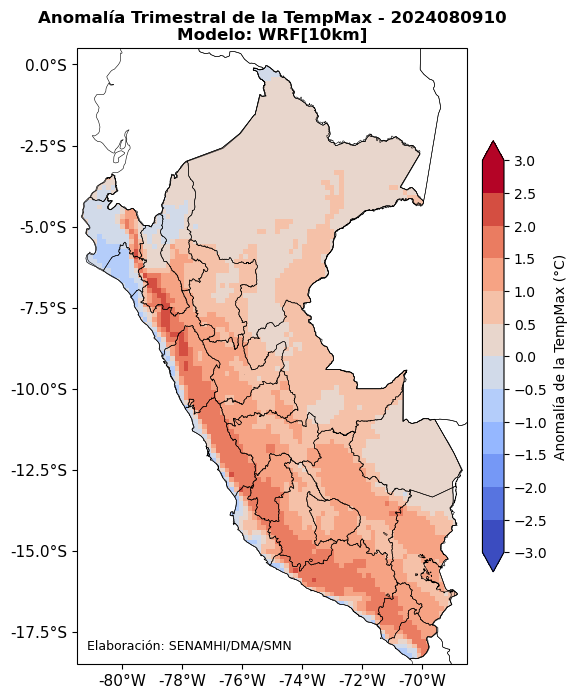

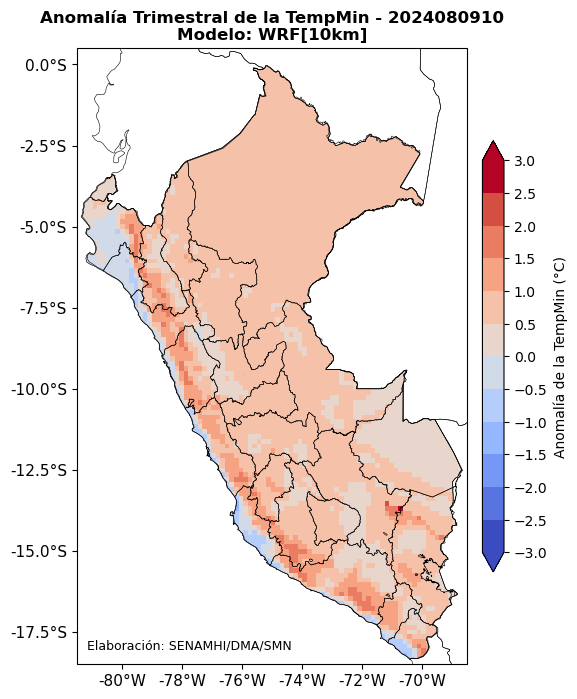

In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.colors import BoundaryNorm

# Función para añadir meses a una fecha
def add_months_to_date(date, months):
    return date + relativedelta(months=months)

def plot_anomaly_trimestral(archivo_pronostico, archivo_climatologia, variable, output_name, name_title):
    # Abrir los archivos NetCDF sin decodificar el tiempo
    ds_pronostico = xr.open_dataset(archivo_pronostico, decode_times=False)
    ds_climatologia = xr.open_dataset(archivo_climatologia, decode_times=False)

    # Extraer el año y mes base desde los atributos de 'time'
    time_units = ds_pronostico['time'].attrs['units']
    fecha_base_str = time_units.split('since')[-1].strip()
    fecha_base = datetime.strptime(fecha_base_str, "%Y-%m-%d %H:%M:%S")

    # Calcular las fechas reales de los tres primeros tiempos
    meses_desde_base = ds_pronostico['time'].isel(time=slice(0, 3)).values
    fechas_reales = [add_months_to_date(fecha_base, int(meses)) for meses in meses_desde_base]

    # Formatear la fecha en el formato YYYYmes1mes2mes3
    fecha_str = f'{fechas_reales[0].year}{fechas_reales[0].month:02d}{fechas_reales[1].month:02d}{fechas_reales[2].month:02d}'

    # Acceder a las variables de temperatura máxima o mínima (variable 't')
    pronostico_var = ds_pronostico[variable]
    climatologia_var = ds_climatologia[variable]

    # Crear colormap discreto con 13 niveles
    cmap = plt.get_cmap('coolwarm', 12)
    norm = BoundaryNorm(np.arange(-3, 3.5, 0.5), cmap.N)

    # Calcular el promedio trimestral para los primeros tres meses
    pronostico_var_trimestral = pronostico_var.isel(time=slice(0, 3)).mean(dim='time')
    climatologia_var_trimestral = climatologia_var.isel(time=slice(0, 3)).mean(dim='time')

    # Calcular la anomalía para el promedio trimestral
    anomalia_var_trimestral = pronostico_var_trimestral - climatologia_var_trimestral

    # Crear el gráfico de la anomalía trimestral
    plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Definir los límites geográficos para Perú
    lon_min, lon_max = -81.5, -68.5
    lat_min, lat_max = -18.5, 0.5

    # Graficar la anomalía
    img = anomalia_var_trimestral.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

    # Configurar los límites del mapa para Perú
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Añadir shapefiles de Sudamérica y Perú con los grosores de línea ajustados
    sudamerica.boundary.plot(ax=ax, edgecolor='black', linewidth=0.4)
    peru.boundary.plot(ax=ax, edgecolor='black', linewidth=0.4)

    # Añadir shapefile de Sudamérica sin Perú
    sudamerica_noperu = gpd.read_file(ruta_shapefile_sudamerica)
    sudamerica_noperu.plot(ax=ax, edgecolor='black', facecolor='white', linewidth=0.1, zorder=1)

    # Añadir la barra de colores con los valores de -3 a 3 y frecuencia de 0.5
    cbar = plt.colorbar(img, ax=ax, orientation='vertical', pad=0.02, ticks=np.arange(-3, 4, 0.5), extend='both',shrink=0.7, aspect=20)
    cbar.set_label(f'Anomalía de la {output_name} (°C)')

    # Configurar las etiquetas de latitud y longitud en los ejes (de 3 en 3 grados)
    ax.set_xticks(np.arange(-80, -68, 2), crs=ccrs.PlateCarree())  # Longitudes
    ax.set_yticks(np.arange(-17.5, 2.5, 2.5), crs=ccrs.PlateCarree())  # Latitudes
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}°W'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y}°S'))
    # Ajustar el tamaño de la fuente de los ticks en los ejes
    ax.tick_params(axis='both', which='major', labelsize=11)  # Cambia el valor
   
    # Añadir nombres a los ejes
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Añadir la leyenda de texto en la parte inferior derecha
    ax.text(0.55, 0.02, 'Elaboración: SENAMHI/DMA/SMN', horizontalalignment='right', verticalalignment='bottom', 
            transform=ax.transAxes, fontsize=9, color='black', 
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    # Añadir el título utilizando la fecha en formato YYYYmes1mes2mes3
    plt.title(f'Anomalía Trimestral de la {name_title} - {fecha_str}\nModelo: WRF[10km]', fontsize=12, fontweight='bold')

    # Guardar el gráfico en la ruta especificada
    nombre_archivo = f'pre_smnwrf_{fecha_str}_anom{output_name}_wrf.png'
    ruta_archivo = f'/scratch/DMA/SMN/CLIMA/web_figuras/prediccion/trimestral/{nombre_archivo}'
    plt.savefig(ruta_archivo, dpi=300, bbox_inches='tight')

    # Mostrar el gráfico
    plt.show()

# Shapefiles para Sudamérica y Perú
ruta_shapefile_sudamerica = '/scratch/shape/SHAPES/SUDA_NUEVO_SIN_PERU_3.shp'
ruta_shapefile_peru = '/scratch/shape/PER/DEPARTAMENTOS.shp'
sudamerica = gpd.read_file(ruta_shapefile_sudamerica)
peru = gpd.read_file(ruta_shapefile_peru)

# Graficar promedio trimestral de Tmax
plot_anomaly_trimestral(
    archivo_pronostico="/scratch/DMA/SMN/CLIMA/c3s_cfsv2/wrf391/wrf_post/2024/07/tmax.tmin/mes_ensemble_tmax_peru.nc",
    archivo_climatologia="/scratch/DMA/SMN/CLIMA/enandes/respaldo/BKrespaldo/CLUSTER-COMPLEMENTARIO/EXTRACCION-CLIM/07-1982.2010/tmax.tmin/prom.tmax.clima.nc",
    variable="t",
    name_title="TempMax",
    output_name="TempMax"
)

# Graficar promedio trimestral de Tmin
plot_anomaly_trimestral(
    archivo_pronostico="/scratch/DMA/SMN/CLIMA/c3s_cfsv2/wrf391/wrf_post/2024/07/tmax.tmin/mes_ensemble_tmin_peru.nc",
    archivo_climatologia="/scratch/DMA/SMN/CLIMA/enandes/respaldo/BKrespaldo/CLUSTER-COMPLEMENTARIO/EXTRACCION-CLIM/07-1982.2010/tmax.tmin/prom.tmin.clima.nc",
    variable="t",
    name_title="TempMin",
    output_name="TempMin"
)
